In [1]:
# módulos básicos
import numpy as np
import pandas as pd

# módulos de visualização
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# módulo para modelagem de redes neurais
import tensorflow as tf

# funções customizadas

## função para geração de inputs e seus respectivos outputs dos modelos
from data_preparation_functions import model_in_out_generator

## função de regra de detecção gaussian tail
from fault_detection_functions import mahalanobis_distance_rule

## função para análise de resultados
from results_analysis_functions import detection_results

# Treinamento

### Dados de treinamento

In [2]:
df_train = pd.read_csv('datasets/confidencial/df_train.csv', delimiter=',')
df_train.head()

,timestamp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,fault
0,2021-06-01 00:00:00,4.820679,5.008938,27.880791,28.154675,0.956431,0.55,100.0,8539.384766,1370.217407,1.731934,1.215717,542.562378,542.937134,50.184551,333.826599,3999.373047,39.244167,0
1,2021-06-01 00:01:00,4.820952,5.008938,28.111809,28.127951,0.951423,0.55,100.0,8511.902344,1368.905762,1.731030,1.212713,542.260864,542.937134,50.396320,333.844940,3994.509277,39.245514,0
2,2021-06-01 00:02:00,4.821226,5.008938,28.071926,28.101227,0.961223,0.55,100.0,8483.062500,1369.733887,1.731332,1.215683,542.770996,542.937134,50.418854,333.552643,4005.993164,39.246860,0
3,2021-06-01 00:03:00,4.821499,5.008938,27.736803,28.074503,0.951415,0.55,100.0,8445.349609,1368.666870,1.730829,1.219262,542.977905,542.937134,50.365505,333.465454,3995.365967,39.248207,0
4,2021-06-01 00:04:00,4.821773,5.008938,27.485134,28.047777,0.951445,0.55,100.0,8418.049805,1368.864868,1.731332,1.218987,542.794250,542.945679,50.420170,333.637848,4000.796143,39.249554,0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20161 entries, 0 to 20160
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  20161 non-null  object 
 1   x1         20161 non-null  float64
 2   x2         20161 non-null  float64
 3   x3         20161 non-null  float64
 4   x4         20161 non-null  float64
 5   x5         20161 non-null  float64
 6   x6         20161 non-null  float64
 7   x7         20161 non-null  float64
 8   x8         20161 non-null  float64
 9   x9         20161 non-null  float64
 10  x10        20161 non-null  float64
 11  x11        20161 non-null  float64
 12  x12        20161 non-null  float64
 13  x13        20161 non-null  float64
 14  x14        20161 non-null  float64
 15  x15        20161 non-null  float64
 16  x16        20161 non-null  float64
 17  x17        20161 non-null  float64
 18  fault      20161 non-null  int64  
dtypes: float64(17), int64(1), object(1)
memory usa

### Pré-processamento dos dados de treinamento

In [4]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20161 entries, 0 to 20160
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  20161 non-null  datetime64[ns]
 1   x1         20161 non-null  float64       
 2   x2         20161 non-null  float64       
 3   x3         20161 non-null  float64       
 4   x4         20161 non-null  float64       
 5   x5         20161 non-null  float64       
 6   x6         20161 non-null  float64       
 7   x7         20161 non-null  float64       
 8   x8         20161 non-null  float64       
 9   x9         20161 non-null  float64       
 10  x10        20161 non-null  float64       
 11  x11        20161 non-null  float64       
 12  x12        20161 non-null  float64       
 13  x13        20161 non-null  float64       
 14  x14        20161 non-null  float64       
 15  x15        20161 non-null  float64       
 16  x16        20161 non-null  float64      

In [5]:
X_train, X_train_timestamps, Y_train, Y_train_timestamps, Y_train_label = model_in_out_generator(df_train, input_width=1, input_features=['x1'], label_features=['x1'])

100%|███████████████████████████████████████████████████████████████████████████| 20160/20160 [00:22<00:00, 916.03it/s]

X shape: (20160, 1, 1)
X_timestamps shape: (20160,)
Y shape: (20160, 1)
Y_timestamps shape: (20160,)
Y_label shape: (20160,)


In [6]:
# inputs devem ter rank 2 para utilizar a função tf.keras.preprocessing.timeseries_dataset_from_array()
X_train = np.squeeze(X_train, axis=-1)
X_train.shape

(20160, 1)

In [7]:
# data tensors devem ser do tipo float32 no tensorflow 2
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
print(f'X_train data type: {X_train.dtype}')
print(f'Y_train data type: {Y_train.dtype}')

X_train data type: float32
Y_train data type: float32


In [8]:
train_gen = tf.keras.preprocessing.timeseries_dataset_from_array(data=X_train, targets=Y_train, sequence_length=1, sequence_stride=1, sampling_rate=1, batch_size=32, shuffle=False)

In [9]:
# checagem da geração de batches
for batch in train_gen:
    inputs, outputs = batch
    print('Input Batch:')
    print(inputs.shape)

    print('\nOutput Batch:')
    print(outputs.shape)
    
    break

Input Batch:
(32, 1, 1)

Output Batch:
(32, 1)


### Modelo Bayesian LSTM (MC Dropout)

In [10]:
class BayesianLSTM(tf.keras.Model):
    def __init__(self):
        super(BayesianLSTM, self).__init__()
        self.lstm = tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3, return_sequences=True) # como a sequência tem comprimento igual a 1, o return_sequences não faz diferença
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense = tf.keras.layers.Dense(1)
    
    def call(self, x):
        x = self.lstm(x)
        x = self.dropout(x)
        return self.dense(x)

**Checagem das dimensões do modelo**

In [11]:
model_test = BayesianLSTM()
model_test(tf.ones((32, 1, 1)))
model_test.summary()

Model: "bayesian_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  4352      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Treinamento do modelo 

In [12]:
brnn = BayesianLSTM()

loss_metric = tf.keras.losses.MeanSquaredError()
training_avg_loss = tf.keras.metrics.Mean()

optimizer = tf.keras.optimizers.Adam()

loss_log = []

EPOCHS = 20

for epoch in range(EPOCHS):
    
    print('\nEpoch %d' % (epoch, ))
    
    # loss reset para cada epoch
    training_avg_loss.reset_states()
    
    for step, (x_batch, y_batch) in enumerate(train_gen):
        
        with tf.GradientTape() as tape:
            predictions = brnn(x_batch, training=True)
            loss = loss_metric(y_batch, predictions)
        
        gradients = tape.gradient(loss, brnn.trainable_weights)
        optimizer.apply_gradients(zip(gradients, brnn.trainable_weights))
        
        # update training metric
        training_avg_loss.update_state(loss)
        
    print('Training average loss over epoch: %.4f' % (float(training_avg_loss.result()),))
    loss_log.append(float(training_avg_loss.result()))


Epoch 0
Training average loss over epoch: 7.1964

Epoch 1
Training average loss over epoch: 0.9249

Epoch 2
Training average loss over epoch: 0.4717

Epoch 3
Training average loss over epoch: 0.4049

Epoch 4
Training average loss over epoch: 0.3732

Epoch 5
Training average loss over epoch: 0.3538

Epoch 6
Training average loss over epoch: 0.3339

Epoch 7
Training average loss over epoch: 0.3289

Epoch 8
Training average loss over epoch: 0.3112

Epoch 9
Training average loss over epoch: 0.3000

Epoch 10
Training average loss over epoch: 0.2826

Epoch 11
Training average loss over epoch: 0.2719

Epoch 12
Training average loss over epoch: 0.2618

Epoch 13
Training average loss over epoch: 0.2472

Epoch 14
Training average loss over epoch: 0.2411

Epoch 15
Training average loss over epoch: 0.2306

Epoch 16
Training average loss over epoch: 0.2232

Epoch 17
Training average loss over epoch: 0.2150

Epoch 18
Training average loss over epoch: 0.2097

Epoch 19
Training average loss over epoc

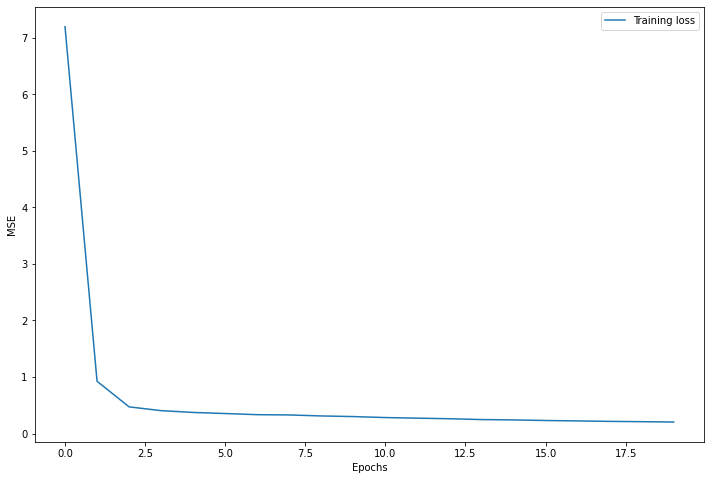

In [13]:
plt.figure(figsize=(12,8))
plt.plot(range(EPOCHS), loss_log, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Testes

### Dados de teste 1

In [14]:
df_test1 = pd.read_csv('datasets/confidencial/df_test1.csv', delimiter=',')
df_test1.head()

,timestamp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,fault
0,2011-05-15 00:00:00,4.774647,5.0,41.235447,41.054737,0.711813,0.4,100.0,9113.216797,1001.702148,1.620825,1.281797,534.477234,534.429382,48.674740,250.269608,4518.571289,31.947456,0
1,2011-05-15 00:01:00,4.775790,5.0,41.030991,41.056587,0.706777,0.4,100.0,9088.170898,999.734985,1.622454,1.281679,534.487915,534.448791,48.673882,250.622223,4507.051758,31.944284,0
2,2011-05-15 00:02:00,4.776933,5.0,41.322945,41.058437,0.712554,0.4,100.0,9088.625000,999.797058,1.621738,1.281561,534.435059,534.463928,48.700249,250.930069,4528.894043,31.941114,0
3,2011-05-15 00:03:00,4.778075,5.0,40.994583,41.060284,0.717025,0.4,100.0,9159.108398,1001.367004,1.620782,1.281442,534.640808,534.490112,48.613491,251.214172,4543.851074,31.937942,0
4,2011-05-15 00:04:00,4.779218,5.0,41.411636,41.062134,0.693954,0.4,100.0,9169.337891,1003.351440,1.619820,1.281324,534.741455,534.510681,48.550117,251.337784,4528.670898,31.934771,0


In [15]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14401 entries, 0 to 14400
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  14401 non-null  object 
 1   x1         14401 non-null  float64
 2   x2         14401 non-null  float64
 3   x3         14401 non-null  float64
 4   x4         14401 non-null  float64
 5   x5         14401 non-null  float64
 6   x6         14401 non-null  float64
 7   x7         14401 non-null  float64
 8   x8         14401 non-null  float64
 9   x9         14401 non-null  float64
 10  x10        14401 non-null  float64
 11  x11        14401 non-null  float64
 12  x12        14401 non-null  float64
 13  x13        14401 non-null  float64
 14  x14        14401 non-null  float64
 15  x15        14401 non-null  float64
 16  x16        14401 non-null  float64
 17  x17        14401 non-null  float64
 18  fault      14401 non-null  int64  
dtypes: float64(17), int64(1), object(1)
memory usa

### Pré-processamento dos dados de teste 1

In [16]:
df_test1['timestamp'] = pd.to_datetime(df_test1['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14401 entries, 0 to 14400
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  14401 non-null  datetime64[ns]
 1   x1         14401 non-null  float64       
 2   x2         14401 non-null  float64       
 3   x3         14401 non-null  float64       
 4   x4         14401 non-null  float64       
 5   x5         14401 non-null  float64       
 6   x6         14401 non-null  float64       
 7   x7         14401 non-null  float64       
 8   x8         14401 non-null  float64       
 9   x9         14401 non-null  float64       
 10  x10        14401 non-null  float64       
 11  x11        14401 non-null  float64       
 12  x12        14401 non-null  float64       
 13  x13        14401 non-null  float64       
 14  x14        14401 non-null  float64       
 15  x15        14401 non-null  float64       
 16  x16        14401 non-null  float64      

In [17]:
X_test1, X_test1_timestamps, Y_test1, Y_test1_timestamps, Y_test1_label = model_in_out_generator(df_test1, input_width=1, input_features=['x1'], label_features=['x1'])

100%|██████████████████████████████████████████████████████████████████████████| 14400/14400 [00:13<00:00, 1071.56it/s]

X shape: (14400, 1, 1)
X_timestamps shape: (14400,)
Y shape: (14400, 1)
Y_timestamps shape: (14400,)
Y_label shape: (14400,)


In [18]:
# inputs devem ter rank 2 para utilizar a função tf.keras.preprocessing.timeseries_dataset_from_array()
X_test1 = np.squeeze(X_test1, axis=-1)
X_test1.shape

(14400, 1)

In [19]:
# data tensors devem ser do tipo float32 no tensorflow 2
X_test1 = X_test1.astype(np.float32)
Y_test1 = Y_test1.astype(np.float32)
print(f'X_train data type: {X_test1.dtype}')
print(f'Y_train data type: {Y_test1.dtype}')

X_train data type: float32
Y_train data type: float32


In [20]:
test1_gen = tf.keras.preprocessing.timeseries_dataset_from_array(data=X_test1, targets=Y_test1, sequence_length=1, sequence_stride=1, sampling_rate=1, batch_size=32, shuffle=False)

In [21]:
# checagem da geração de batches
for batch in test1_gen:
    inputs, outputs = batch
    print('Input Batch:')
    print(inputs.shape)

    print('\nOutput Batch:')
    print(outputs.shape)
    
    break

Input Batch:
(32, 1, 1)

Output Batch:
(32, 1)


### Teste 1 do modelo

In [22]:
test1_avg_loss = tf.keras.metrics.Mean()
test1_avg_loss.reset_states()

T = 100

for step, (x_batch_test1, y_batch_test1) in enumerate(tqdm(test1_gen)):
    
    for t in range(T):
        predictions = brnn(x_batch_test1, training=True) # training=True para dropout ativado
        if t == 0:
            batch_mc_samples = predictions
        else:
            batch_mc_samples = tf.concat([batch_mc_samples, predictions], axis=-1)
    
    if step == 0:
        Y_mc_samples_test1 = batch_mc_samples
    else:
        Y_mc_samples_test1 = tf.concat([Y_mc_samples_test1, batch_mc_samples], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [04:00<00:00,  1.87it/s]


**Predictions tensor**

In [23]:
Y_mc_samples_test1.shape

TensorShape([14400, 1, 100])

In [24]:
Y_mc_samples_test1 = tf.squeeze(Y_mc_samples_test1).numpy()
Y_mc_samples_test1.shape

(14400, 100)

### Detecção das falhas no conjunto de dados de teste 1

In [25]:
df_test1_detect = mahalanobis_distance_rule(Y_test1_timestamps, Y_test1, Y_mc_samples_test1, Y_test1_label, z_threshold=2.5)

### Resultados do teste 1

In [26]:
test1_results = detection_results(df_test1_detect)

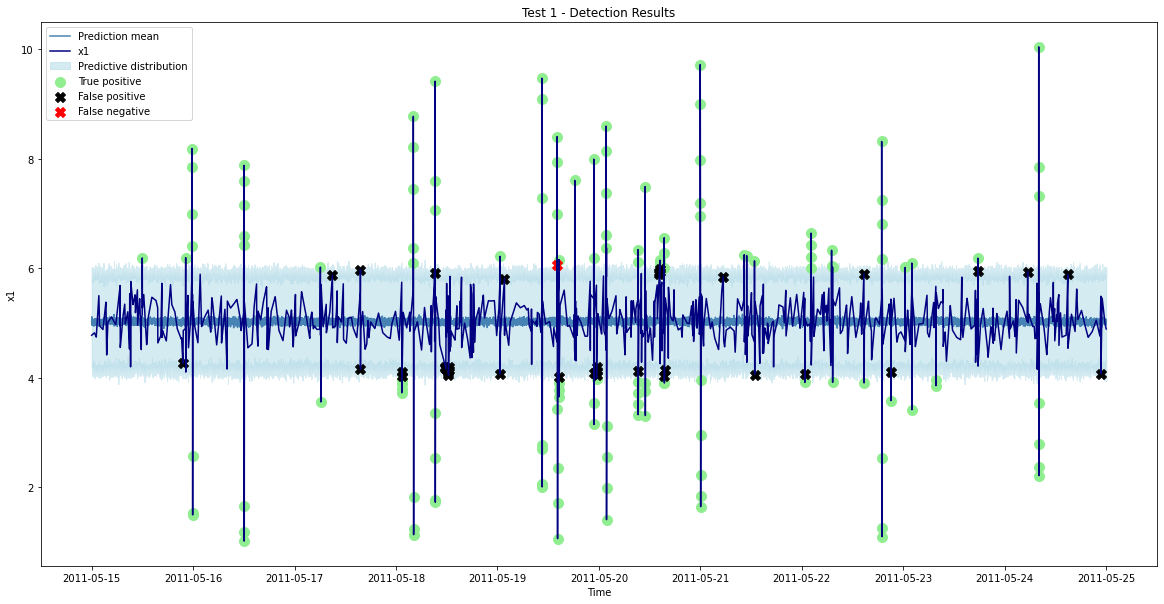

In [27]:
test1_results.detection_result_prob_plot('Test 1 - Detection Results', 'Time', 'x1', 2.5)

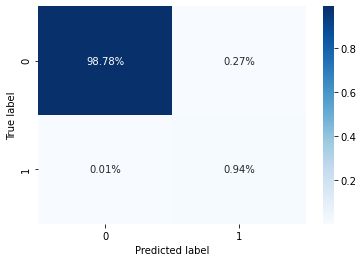

In [28]:
cfm_test1 = test1_results.detection_confusion_matrix()

In [29]:
test1_results.detection_result_metrics()

Detection performance metrics:

True negative: 14224
False positive: 39
False negative: 1
True positive: 136
True positive rate (TPR): 0.9927007299270073
True negative rate (TNR): 0.9972656523872958
False positive rate (FPR): 0.0027343476127041997
Precision: 0.7771428571428571
Accuracy: 0.9972222222222222
Balanced accuracy: 0.9949831911571516
F1 score: 0.8717948717948717


### Dados de teste 2

In [30]:
df_test2 = pd.read_csv('datasets/confidencial/df_test2.csv', delimiter=',')
df_test2.head()

,timestamp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,fault
0,2012-04-01 00:00:00,4.241906,5.038079,41.330364,41.884705,0.785922,0.4,100.0,9203.445313,1000.187256,1.510093,1.188423,538.560120,538.563660,44.496689,273.757263,4549.782227,31.182013,0
1,2012-04-01 00:01:00,4.282500,5.038079,40.937592,41.895687,0.800040,0.4,100.0,9206.594727,1000.715393,1.510778,1.188279,538.491943,538.573059,44.499447,273.931152,4549.725586,31.180729,0
2,2012-04-01 00:02:00,4.294424,5.038079,41.556946,41.906670,0.761630,0.4,100.0,9209.744141,998.984009,1.510941,1.188135,538.887451,538.582459,44.474369,274.256867,4549.668457,31.179445,0
3,2012-04-01 00:03:00,4.306348,5.038079,41.592968,41.917652,0.757114,0.4,100.0,9212.893555,998.743164,1.510920,1.187991,538.784302,538.588379,44.415276,274.679749,4549.611328,31.178162,0
4,2012-04-01 00:04:00,4.318272,5.038079,41.646286,41.928631,0.756584,0.4,100.0,9216.043945,999.936157,1.511907,1.187846,538.687256,538.590576,44.367886,274.962402,4549.532715,31.176878,0


In [31]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12961 entries, 0 to 12960
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  12961 non-null  object 
 1   x1         12961 non-null  float64
 2   x2         12961 non-null  float64
 3   x3         12961 non-null  float64
 4   x4         12961 non-null  float64
 5   x5         12961 non-null  float64
 6   x6         12961 non-null  float64
 7   x7         12961 non-null  float64
 8   x8         12961 non-null  float64
 9   x9         12961 non-null  float64
 10  x10        12961 non-null  float64
 11  x11        12961 non-null  float64
 12  x12        12961 non-null  float64
 13  x13        12961 non-null  float64
 14  x14        12961 non-null  float64
 15  x15        12961 non-null  float64
 16  x16        12961 non-null  float64
 17  x17        12961 non-null  float64
 18  fault      12961 non-null  int64  
dtypes: float64(17), int64(1), object(1)
memory usa

### Pré-processamento dos dados de teste 2

In [32]:
df_test2['timestamp'] = pd.to_datetime(df_test2['timestamp'], format='%Y-%m-%d %H:%M:%S')
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12961 entries, 0 to 12960
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  12961 non-null  datetime64[ns]
 1   x1         12961 non-null  float64       
 2   x2         12961 non-null  float64       
 3   x3         12961 non-null  float64       
 4   x4         12961 non-null  float64       
 5   x5         12961 non-null  float64       
 6   x6         12961 non-null  float64       
 7   x7         12961 non-null  float64       
 8   x8         12961 non-null  float64       
 9   x9         12961 non-null  float64       
 10  x10        12961 non-null  float64       
 11  x11        12961 non-null  float64       
 12  x12        12961 non-null  float64       
 13  x13        12961 non-null  float64       
 14  x14        12961 non-null  float64       
 15  x15        12961 non-null  float64       
 16  x16        12961 non-null  float64      

In [33]:
X_test2, X_test2_timestamps, Y_test2, Y_test2_timestamps, Y_test2_label = model_in_out_generator(df_test2, input_width=1, input_features=['x1'], label_features=['x1'])

100%|██████████████████████████████████████████████████████████████████████████| 12960/12960 [00:12<00:00, 1067.73it/s]

X shape: (12960, 1, 1)
X_timestamps shape: (12960,)
Y shape: (12960, 1)
Y_timestamps shape: (12960,)
Y_label shape: (12960,)


In [34]:
# inputs devem ter rank 2 para utilizar a função tf.keras.preprocessing.timeseries_dataset_from_array()
X_test2 = np.squeeze(X_test2, axis=-1)
X_test2.shape

(12960, 1)

In [35]:
# data tensors devem ser do tipo float32 no tensorflow 2
X_test2 = X_test2.astype(np.float32)
Y_test2 = Y_test2.astype(np.float32)
print(f'X_train data type: {X_test2.dtype}')
print(f'Y_train data type: {Y_test2.dtype}')

X_train data type: float32
Y_train data type: float32


In [36]:
test2_gen = tf.keras.preprocessing.timeseries_dataset_from_array(data=X_test2, targets=Y_test2, sequence_length=1, sequence_stride=1, sampling_rate=1, batch_size=32, shuffle=False)

In [37]:
# checagem da geração de batches
for batch in test2_gen:
    inputs, outputs = batch
    print('Input Batch:')
    print(inputs.shape)

    print('\nOutput Batch:')
    print(outputs.shape)
    
    break

Input Batch:
(32, 1, 1)

Output Batch:
(32, 1)


### Teste 2 do modelo

In [38]:
test2_avg_loss = tf.keras.metrics.Mean()
test2_avg_loss.reset_states()

T = 100

for step, (x_batch_test2, y_batch_test2) in enumerate(tqdm(test2_gen)):
    
    for t in range(T):
        predictions = brnn(x_batch_test2, training=True) # training=True para dropout ativado
        if t == 0:
            batch_mc_samples = predictions
        else:
            batch_mc_samples = tf.concat([batch_mc_samples, predictions], axis=-1)
    
    if step == 0:
        Y_mc_samples_test2 = batch_mc_samples
    else:
        Y_mc_samples_test2 = tf.concat([Y_mc_samples_test2, batch_mc_samples], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 405/405 [03:44<00:00,  1.80it/s]


**Predictions tensor**

In [39]:
Y_mc_samples_test2.shape

TensorShape([12960, 1, 100])

In [40]:
Y_mc_samples_test2 = tf.squeeze(Y_mc_samples_test2).numpy()
Y_mc_samples_test2.shape

(12960, 100)

### Detecção das falhas no conjunto de dados de teste 2

In [41]:
df_test2_detect = mahalanobis_distance_rule(Y_test2_timestamps, Y_test2, Y_mc_samples_test2, Y_test2_label, z_threshold=2.5)

### Resultados do teste 2

In [42]:
test2_results = detection_results(df_test2_detect)

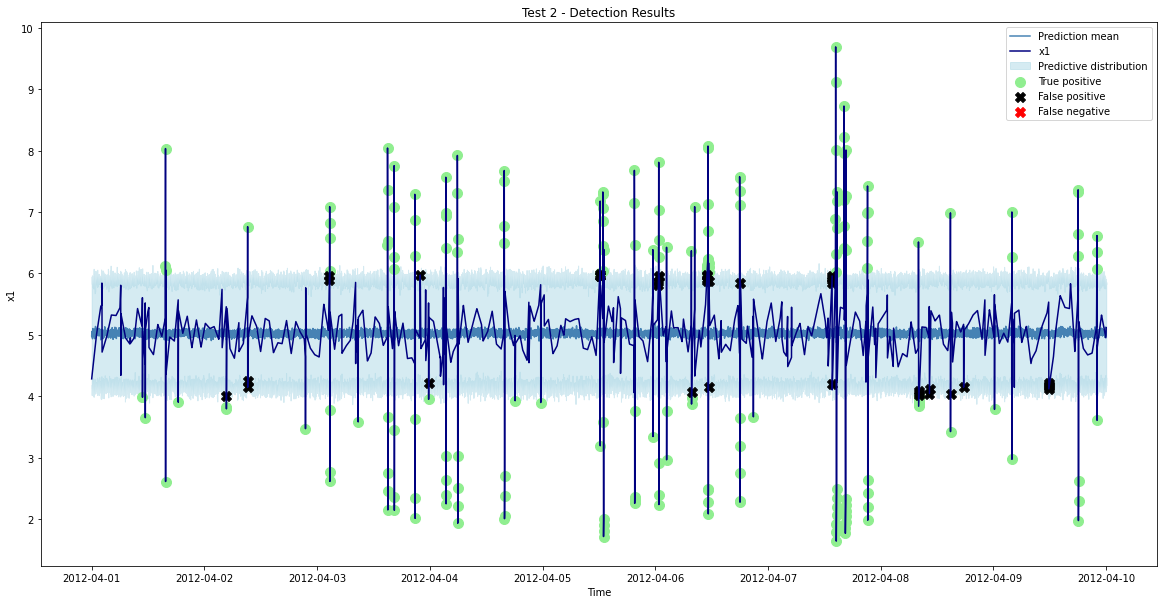

In [43]:
test2_results.detection_result_prob_plot('Test 2 - Detection Results', 'Time', 'x1', 2.5)

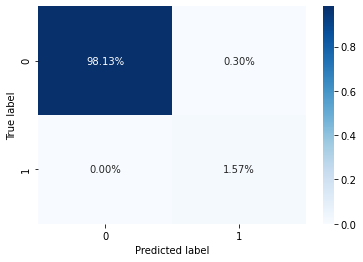

In [44]:
cfm_test2 = test2_results.detection_confusion_matrix()

In [45]:
test2_results.detection_result_metrics()

Detection performance metrics:

True negative: 12718
False positive: 39
False negative: 0
True positive: 203
True positive rate (TPR): 1.0
True negative rate (TNR): 0.9969428549031905
False positive rate (FPR): 0.003057145096809595
Precision: 0.8388429752066116
Accuracy: 0.9969907407407408
Balanced accuracy: 0.9984714274515952
F1 score: 0.9123595505617977
